# merge_sim&copy; Tutorial
* This tutorial shows how to use merge_sim to reproduce the result in my graduate thesis.
* Author: [chaonan99](chaonan99.github.io)
* Date: 2017/06/10
* Code for this tutorial and the project is under MIT license. See the license file for detail.

In [1]:
from game import Case1VehicleGenerator, MainHigherSpeedVG, GameLoop
%matplotlib inline

## Case 1
This simulate the simple case in original paper, where 2 cars in each lane start at the same speed.

Calculating tm for v0=13.4, vt=25.0, p0=-400.0, pt=0, tm=21.162899486487618
Calculating tm for v0=13.4, vt=25.0, p0=-400.0, pt=0, tm=21.162899486487618
Average merging time: 21.64499999999974 s
Traffic flow: 0.15420200462606 vehicle/s
Average speed: 71.53096270421067 km/h
Average fuel consumption: 7.946694797022417 ml/vehicle


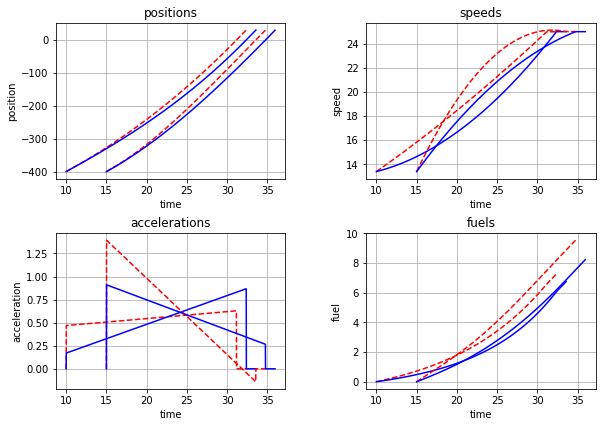

In [2]:
vehicle_generator = Case1VehicleGenerator()
game = GameLoop(vehicle_generator)
game.play()
game.draw_result_pyplot()

## Case 2
In this case, the main lane starts with a higher speed.

Calculating tm for v0=15.0, vt=25.0, p0=-400.0, pt=0, tm=20.213959120616735
Average merging time: 19.75888888888942 s
Traffic flow: 0.4663212435232938 vehicle/s
Average speed: 78.40311215246113 km/h
Average fuel consumption: 8.324185841472211 ml/vehicle


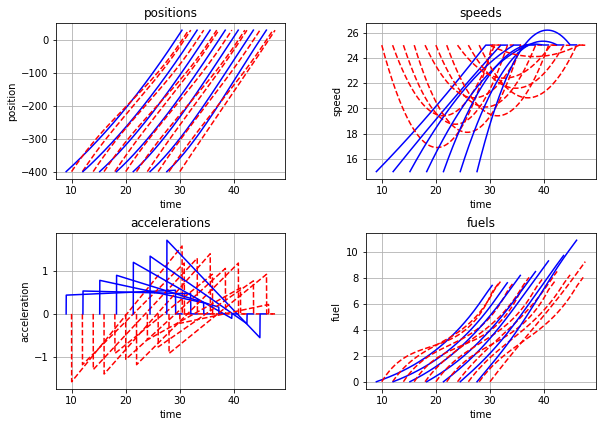

In [3]:
vehicle_generator = MainHigherSpeedVG()
game = GameLoop(vehicle_generator)
game.play()
game.draw_result_pyplot()

## OTM order
Let's now implement OTM order. This can be easily fulfilled using the `SpeedIDAssigner` provided in `VehicleGeneratorBase`.

In [4]:
from common import config, VehicleState
from helper import Helper
from game import VehicleGeneratorBase, VehicleBuilder, OnBoardVehicle
import numpy as np

class MainHigherSpeedVGOTM(VehicleGeneratorBase):
    def __init__(self):
        super(MainHigherSpeedVGOTM, self).__init__()

    def buildSchedule(self):
        # lane0 (main road)
        t0_lane0 = np.arange(10, 30.1, 2.0)  # generate a vehicle every 2.0 seconds from 10 s
        t0_lane1 = np.arange(9, 30.1, 3.1)   # generate a vehicle every 3.1 seconds from 9 s 
        v0_lane0 = 25.0  # v_0 on the main lane
        v0_lane1 = 15.0  # v_0 on the auxiliary lane
        for ti0 in t0_lane0:
            v = VehicleBuilder(-1)\
                .setSpeed(v0_lane0)\
                .setPosition(-config.control_len)\
                .setAcceleration(0)\
                .setLane(0).build()
            # The schedule is the actual vehicle queue used to generate vehicle in the game loop.
            # Append the built vehicle to the schedule.
            self.schedule.append(OnBoardVehicle(v, ti0, Helper.getTc(v)))
        for ti0 in t0_lane1:
            v = VehicleBuilder(-1)\
                .setSpeed(v0_lane1)\
                .setPosition(-config.control_len)\
                .setAcceleration(0)\
                .setLane(1).build()
            self.schedule.append(OnBoardVehicle(v, ti0, Helper.getTc(v)))
        # Use speed ID Assigner to get OTM order.
        self.SpeedIDAssigner()

### Hard $t_\mathrm{m}$ recalculate
The `SpeedGameLoop` implement the hard OTM order stated in the original paper.

Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=15.0, vt=25.0, p0=-400.0, pt=0, tm=20.213959120616735
Calculating tm for v0=15.0, vt=25.0, p0=-400.0, pt=0, tm=20.213959120616735
Calculating 

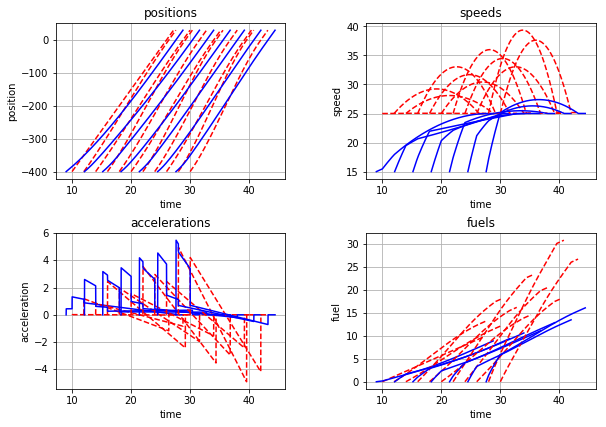

In [5]:
from game import SpeedGameLoop
vehicle_generator = MainHigherSpeedVGOTM()
game = SpeedGameLoop(vehicle_generator)
game.play()
game.draw_result_pyplot()

### Soft $t_\mathrm{m}$ recalculate
We relieve $t_\mathrm{m}$ on the auxiliary lane. The alternative is provided in `Helper.getTm`.

In [6]:
class SpeedSoftGameLoop(GameLoop):
    def __init__(self, vscd):
        super(SpeedSoftGameLoop, self).__init__(vscd)
        self.on_board_vehicles = []

    def nextStep(self):
        self.ctime += config.time_meta
        t = self.ctime
        ove_t = self.vscd.getAtTime(t)
        for v in ove_t:
            tmp_v_stack = []
            while len(self.on_board_vehicles) > 0 and self.on_board_vehicles[-1].vehicle.ID > v.vehicle.ID:
                tmpv = self.on_board_vehicles.pop()
                # tmpv.t0 = t
                # tmpv.min_pass_time = max(tmpv.min_pass_time, Helper.getTmOptimal2(tmpv.vehicle.speed,
                #     config.case_speed['speed_merge'], tmpv.vehicle.position, 0))
                tmp_v_stack.append(tmpv)

            # Get t_m
            if len(self.on_board_vehicles) == 0 and len(self.finished_vehicels) == 0:
                v.tm = v.t0 + max(config.min_pass_time, v.min_pass_time)
            elif len(self.on_board_vehicles) > 0:
                v.tm = Helper.getTm(v, self.on_board_vehicles[-1], 'soft')
            else:
                v.tm = Helper.getTm(v, self.finished_vehicels[-1], 'soft')
            tmp_v_stack.append(v)
            prevve = None
            for i in reversed(range(len(tmp_v_stack))):
                ve = tmp_v_stack[i]
                if prevve is not None:
                    ve.tm = Helper.getTm(ve, prevve, 'soft')
                self.on_board_vehicles.append(ve)
                TimeM = Helper.getTimeMatrix(t, ve.tm)
                ConfV = Helper.getConfigVec(ve)
                # from IPython import embed; embed()
                ve.ParaV = np.dot(np.linalg.inv(TimeM), ConfV)
                ve.state = VehicleState.ON_RAMP
                prevve = ve
                # print("ID {}".format(prevve.vehicle.ID))

        for v in self.on_board_vehicles:
            Helper.updateAVP(v, t)
            if v.vehicle.position >= 0:
                v.state = VehicleState.ON_MERGING

        while not self.isEmpty() and self.on_board_vehicles[0].vehicle.position >= config.merging_len:
            self.on_board_vehicles[0].state = VehicleState.FINISHED
            self.finished_vehicels.append((self.on_board_vehicles.pop(0)))

Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=25.0, vt=25.0, p0=-400.0, pt=0, tm=15.999935266382314
Calculating tm for v0=15.0, vt=25.0, p0=-400.0, pt=0, tm=20.213959120616735
Calculating tm for v0=15.0, vt=25.0, p0=-400.0, pt=0, tm=20.213959120616735
Calculating 

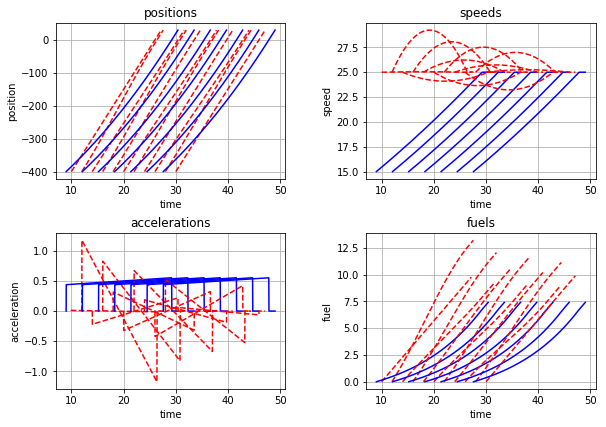

In [7]:
vehicle_generator = MainHigherSpeedVGOTM()
game = SpeedSoftGameLoop(vehicle_generator)
game.play()
game.draw_result_pyplot()

## Exercise
Try to implement a random vehicle generator, which the time interval between two consecutive vehicle on the same lane obeying the exponential distribution and the speed in each lane obeying normal distribution. The answer can be found in `game.py` file.